In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

In [2]:
data_path_file='DelayedFlights.csv'
df = pd.read_csv(data_path_file)

In [3]:
df.columns

Index(['Unnamed: 0', 'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime',
       'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum',
       'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

Haremos uso de los **algoritmos no Supervisados de Agrupacion**

Adoptaremos las **restricciones** en las caracteristicas usadas en la construccion del **modelo de clasificacion**

De acuerdo a estas restricciones, las variables que se consideraran son las incluidas en **features**

In [4]:
features=['DepTime', 'CRSDepTime', 'CRSArrTime',
          'CRSElapsedTime', 'TaxiOut', 'ArrDelay', 'DepDelay', 'Distance', 'UniqueCarrier']

In [5]:
X= df[features]

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936758 entries, 0 to 1936757
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   DepTime         float64
 1   CRSDepTime      int64  
 2   CRSArrTime      int64  
 3   CRSElapsedTime  float64
 4   TaxiOut         float64
 5   ArrDelay        float64
 6   DepDelay        float64
 7   Distance        int64  
 8   UniqueCarrier   object 
dtypes: float64(5), int64(3), object(1)
memory usage: 133.0+ MB


Dada la variablidad en los retrasos entre aerolineas **solo haremos el analisis para una de ellas.** Como el dataset es amplio aun con esta eleccion seguiremos disponiendo de una cantidad de informacion considerable.

Escogemos la **Aerolinea AS** que constituye el 2% de los vuelos.

In [7]:
X = X[ X['UniqueCarrier'] == 'AS' ]
X.drop( columns= 'UniqueCarrier', inplace= True )
X.shape

(39293, 8)

In [8]:
X.isnull().sum()

DepTime             0
CRSDepTime          0
CRSArrTime          0
CRSElapsedTime      0
TaxiOut             7
ArrDelay          283
DepDelay            0
Distance            0
dtype: int64

Para poder **ejecutar KMeans** la matriz de caracteristicas **X no ha de tener faltantes**

Tratandose de un numero relativamente bajo descartaremos las filas con '**ArrDelay**' y '**TaxiOut**' faltantes para toda la matriz de caracteristicas **X**

In [9]:
delay = ~(X['ArrDelay'].isnull())
X= X[delay]
X.shape

(39010, 8)

In [10]:
X.isnull().sum()

DepTime           0
CRSDepTime        0
CRSArrTime        0
CRSElapsedTime    0
TaxiOut           0
ArrDelay          0
DepDelay          0
Distance          0
dtype: int64

Asi pues consideraremos las caracteristicas incluidas en feat_X, resultando la matriz de caracteristicas X

In [11]:
feat_X=['DepTime', 'CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 'TaxiOut', 'ArrDelay', 'DepDelay', 'Distance']
X= X[feat_X]
X.shape

(39010, 8)

In [12]:
X.sample(5)

,DepTime,CRSDepTime,CRSArrTime,CRSElapsedTime,TaxiOut,ArrDelay,DepDelay,Distance
547295,2043.0,2035,25,170.0,8.0,-23.0,8.0,1107
864057,2223.0,2140,23,223.0,8.0,30.0,43.0,1542
1404848,1010.0,1000,1235,215.0,21.0,-8.0,10.0,1449
1405630,2203.0,2135,13,218.0,14.0,12.0,28.0,1533
1720979,2324.0,2300,2357,57.0,12.0,20.0,24.0,261


In [13]:
X.describe().round(3)

,DepTime,CRSDepTime,CRSArrTime,CRSElapsedTime,TaxiOut,ArrDelay,DepDelay,Distance
count,39010.000,39010.000,39010.000,39010.000,39010.000,39010.000,39010.000,39010.000
mean,1489.410,1451.406,1602.334,153.186,15.836,36.061,37.976,947.248
std,484.411,464.526,517.059,76.770,8.562,50.988,48.538,601.202
min,1.000,5.000,1.000,24.000,1.000,-60.000,6.000,31.000
25%,1144.000,1120.000,1256.000,105.000,11.000,8.000,11.000,571.000
50%,1532.000,1500.000,1704.000,149.000,14.000,22.000,21.000,909.000
75%,1857.000,1830.000,2025.000,175.000,19.000,46.000,45.000,1107.000
max,2400.000,2358.000,2359.000,440.000,220.000,948.000,947.000,2846.000


Para los **algortimos** que se basan en el **computo de distancias** entre puntos es importante que las **caracteristicas** se encuentren en una **escala similar** 

Para ello en la etapa de preproceso se debe usar el **feature scaling**

Un ejemplo de feature scaling lo constituye la **standarizacion** de los datos. Cada variable se centra en su valor medio y es dividido por su desviacion estandard.

In [14]:
# Iniciamos una instancia de StandardScaler
scaler = preprocessing.StandardScaler()

In [15]:
# Fit to ALL data and features. Then transform it.
M = scaler.fit_transform(X)

# Volvemos a meter la matriz M en el dataframe X
X = pd.DataFrame(M, columns= feat_X )

In [16]:
scaler.mean_.round(2)

array([1489.41, 1451.41, 1602.33,  153.19,   15.84,   36.06,   37.98,
        947.25])

In [17]:
scaler.scale_.round(2)

array([484.4 , 464.52, 517.05,  76.77,   8.56,  50.99,  48.54, 601.19])

In [18]:
X.sample(5)

,DepTime,CRSDepTime,CRSArrTime,CRSElapsedTime,TaxiOut,ArrDelay,DepDelay,Distance
27246,0.888907,0.847312,0.639522,-1.370172,-1.499292,-0.197319,-0.061309,-1.244603
37330,1.361652,1.460848,1.411204,-0.406236,-0.331273,-0.099257,-0.390952,-0.446191
23887,0.665953,0.642800,0.622115,-0.770969,-0.915282,-0.393445,-0.329144,-0.662428
35101,-0.706867,-1.337737,-0.932853,0.219020,0.135935,2.724948,3.276327,0.011232
7389,0.882713,0.868840,1.215865,0.036653,0.369538,-0.275770,-0.329144,0.127667


---------------------------------

## Ejercicio 1

Clasifica los vuelos con el algoritmo K-Means

--------------------------

In [19]:
# Instanciamos el algortimo KMeans con 8 clusters

kmeans = KMeans( n_clusters=8, n_init=10, init='k-means++', max_iter= 50, algorithm='auto', 
                verbose=0, random_state=33)

In [20]:
# Realizamos los 10 runs, con 50 iteraciones como maximo en cada run.

kmeans.fit(X)

KMeans(max_iter=50, random_state=33)

In [21]:
# El atributo inertia_ de la clase KMeans proporciona el minimo SSE de todas las muestras del mejor run.

round(kmeans.inertia_,2)

116721.9

In [22]:
# Numero de iteraciones del mejor run

kmeans.n_iter_

27

Veamos la variacion del atributo **inertia_** del algortimo **KMeans** en función del parametro **n_clusters**

In [23]:
kmeans_kwargs = { 'init':'k-means++', 'n_init':10, 'max_iter':50, 'random_state':33,  'algorithm':'auto' }

In [24]:
# inertia holds the SSE values for KMeans with  k clusters in range(2,13)

inertia = []

for k in range(2, 13):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

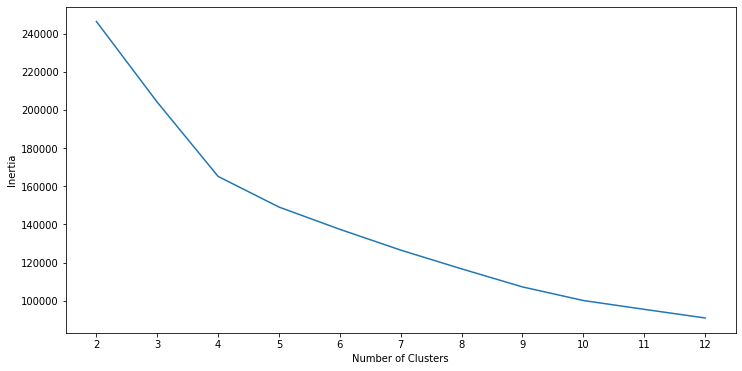

In [25]:
plt.figure(figsize=(12,6))
plt.plot(range(2, 13), inertia)
plt.xticks(range(2, 13))
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

Al incrementarse el numero de cluster se reduce asintoticamente la SSE

-------------------

## Ejercicio 2

Clasifica los vuelos con el algoritmo de clustering jerarquico.

------------------

**linkage(X)** realiza el **clustering Jerarquico Aglomerativo** en la matriz de datos **X**

**dendogram() hace el gráfico** a partir de la matriz de linkage Z resultante.

Este algoritmo no es muy recomendable para datasets con muchos elementos. Con el 5% de los vuelos (alrededor de 100 000 datos) crasheaba. Por ello se optó por una operadora con menos vuelos como AS con el 2% (alrededor de 40 000 vuelos) para que el algoritmo pudiera converger.

El resultado es muy sensible al metodo elegido para computar las distancias entre clusters y las distancias una vez se unen los clusteres. El metodo median proporcionó una separación poco efectiva. El metodo single resultó inestable. El **metodo ward** aunque no es rapido dió buenos resultados en las ocasiones que convergió.

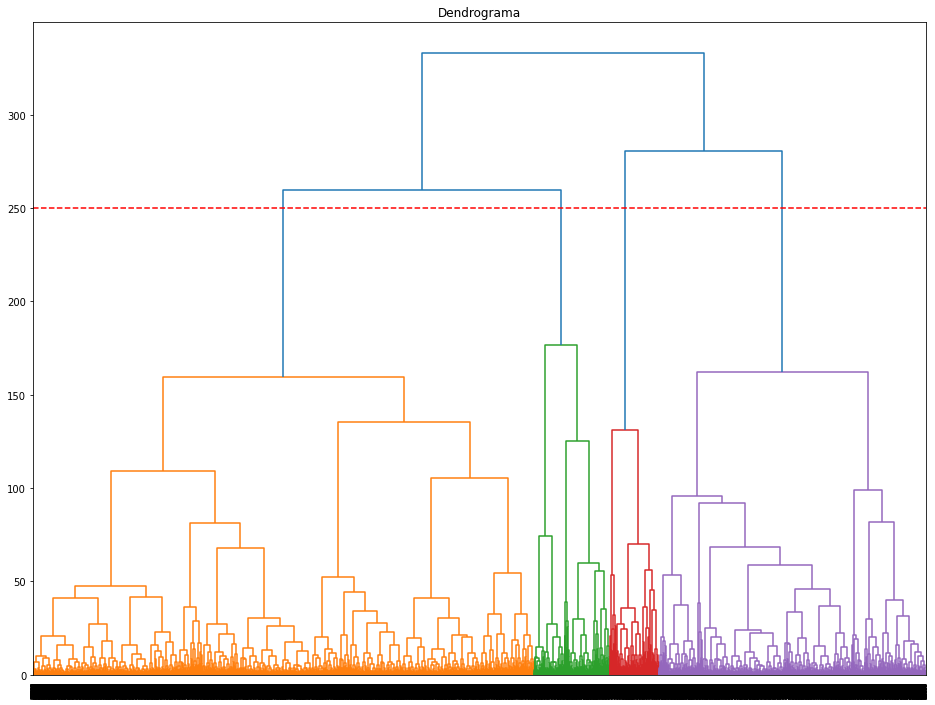

In [26]:
plt.figure(figsize=(16, 12))  
plt.title("Dendrograma")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))
plt.axhline(y=250, color='r', linestyle='--')

El dendograma ayuda a tomar la decision del numero optimo de clusters. 

Un criterio de elección del numero de clusters es la elección del mayor segmento de y que mantiene el mismo número de clusters. 

Vemos como de 165 a 260 se mantienen 4 clusters.

In [27]:
#instanciamos un modelo aglomerativo con los parametro de interes
clustering = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')

# Realizamos el clustering con la matriz de caract estandarizada
clustering.fit(X)

AgglomerativeClustering(n_clusters=4)

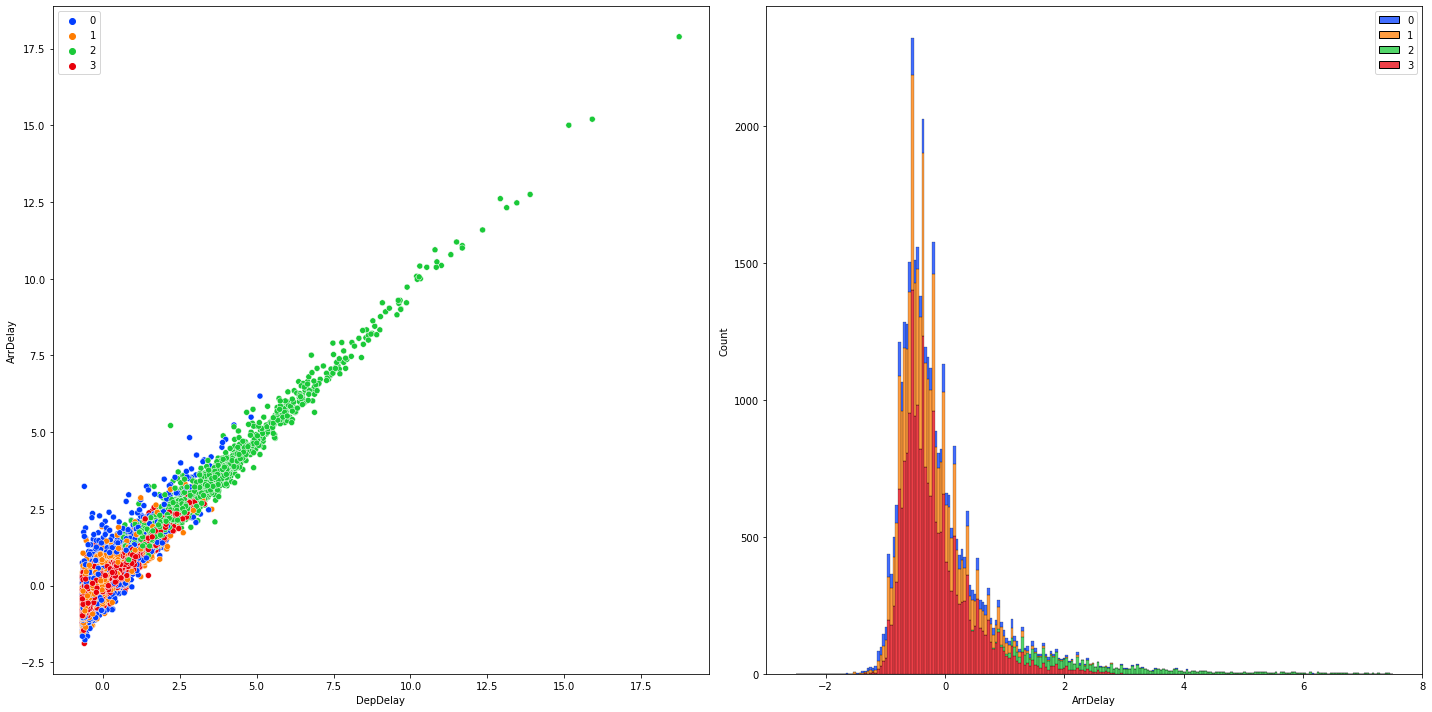

In [39]:
f, axs = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw=dict(width_ratios=[4, 4]))

sns.scatterplot(data=X, x='DepDelay', y='ArrDelay', hue=clustering.labels_, palette='bright', ax=axs[0])
sns.histplot(data=X, x='ArrDelay', hue=clustering.labels_, palette='bright', binrange=[-2.5,7.5], ax=axs[1], multiple='stack')
f.tight_layout()

Observamos los datos separados segun el **clustering jerarquico aglomerativo con 4 clusters**

----------------------------

## Ejercicio 3

Calcula el rendimiento del clustering con un parametro como el silhouette

---------------------------

Observemos la evolución del **coeficiente silhouette variando el numero de clusters** usando el **algoritmo KMeans**

Mostremos una **gráfica** junto el parametro **inertia** para determinar el **número óptimo de clusters**

In [29]:
# silhouette holds silhouette score values for KMean with k clusters on range(2,13)

silhouette = []

for k in range(2, 13):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette.append(score)

<class 'matplotlib.lines.Line2D'>


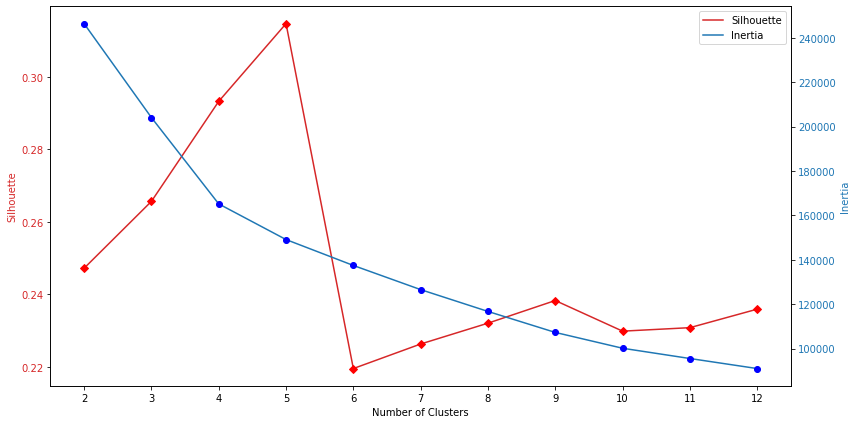

In [30]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# ax1.plot() returns a tuple with 1 element

my_color = 'tab:red'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Silhouette', color=my_color)
line1, = ax1.plot(range(2, 13),silhouette, color=my_color, label='Silhouette')
ax1.plot(range(2, 13), silhouette,'rD')
ax1.set_xticks(range(2,13)) 
ax1.tick_params(axis='y', labelcolor=my_color)
# ax1.grid(axis='x')

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  

# we already handled the x-label with ax1
my_color2 = 'tab:blue'
ax2.set_ylabel('Inertia', color=my_color2)  
(line2,) = ax2.plot(range(2, 13),  inertia, color=my_color2, label='Inertia')
print(type(line2))
plt.plot(range(2, 13), inertia,'bo')
ax2.tick_params(axis='y', labelcolor=my_color2)

fig.tight_layout()
ax2.legend(handles=[line1, line2])
plt.show()

Segun el gráfico con n_clusters=5 obtenemos el mejor coeficiente silhouette de cohesion y separacion de clusters.

Asi pues para este dataset usando el algoritmo KMeans eligiriamos n_clusters=5

In [40]:
# Instanciamos el algortimo KMeans con 5 clusters

kmeans = KMeans( n_clusters=5, n_init=10, init='k-means++', max_iter= 100, algorithm='auto', 
                verbose=0, random_state=33)

In [41]:
kmeans.fit(X)

KMeans(max_iter=100, n_clusters=5, random_state=33)

In [42]:
kmeans.n_iter_

11

Observemos la clusterizacion realizada por kmeans con 5 clusters en los mismos graficos realizados previamente

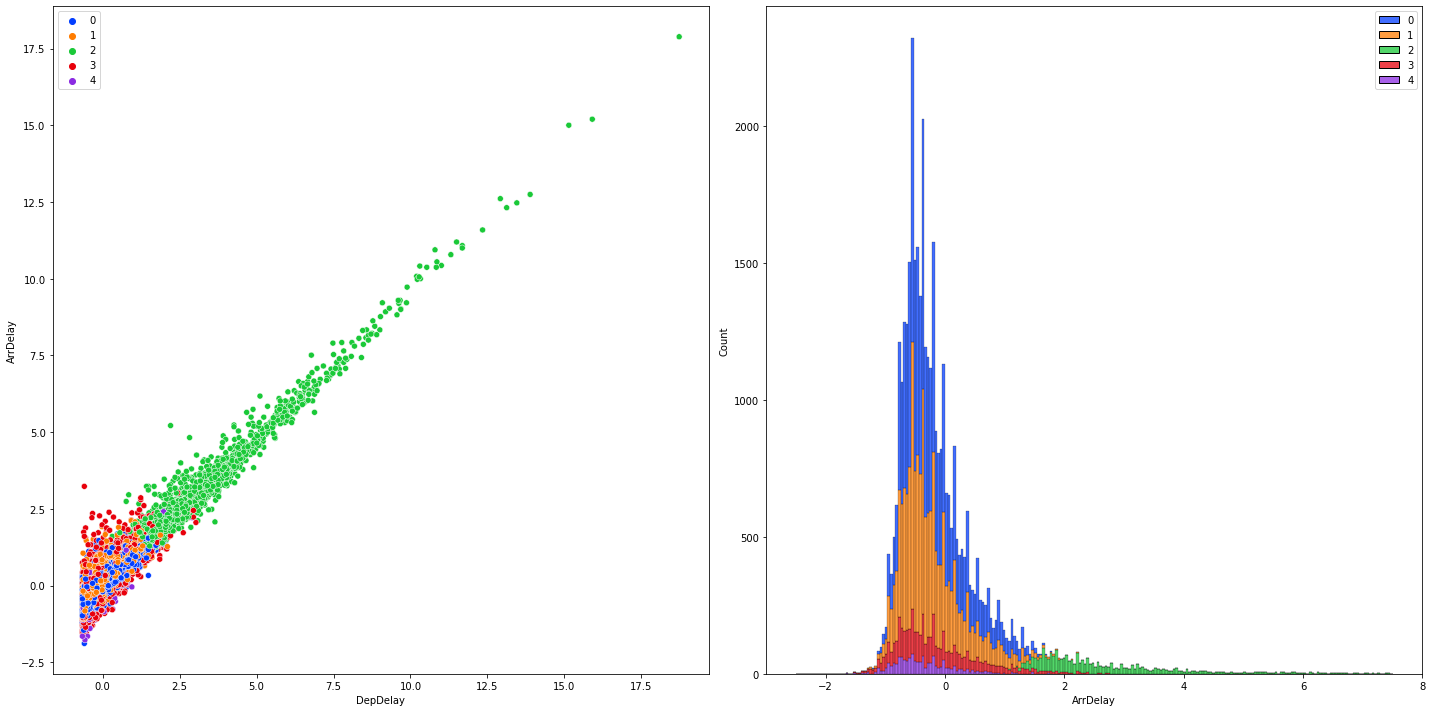

In [43]:
f, axs = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw=dict(width_ratios=[4, 4]))

sns.scatterplot(data=X, x='DepDelay', y='ArrDelay', hue=kmeans.labels_, palette='bright', ax=axs[0])
sns.histplot(data=X, x='ArrDelay', hue=kmeans.labels_, palette='bright', binrange=[-2.5,7.5], ax=axs[1], multiple='stack')
f.tight_layout()